## Index

* Problem
* Solution
    * Exploratory Data Analysis
    * Preprocessing & Feature Engineering
    * Experiment on Model Training
    * Model Evaluation
    * Prediction

### Problem

```
Column, Description
item_id, unique ID
category_class, item category
sold_price, price when the item is sold
price, price when the item is listed
area_name, where the item is listed
condition, item condition (Fair / Good / Like New)
size, shipping size
listing_at, listing datetime
item_tag_hash, hashed item tag

Testing data set (test.csv) doesn't have the "category_class" column. Let's try to predict the
"category_class" of the testing data set.
NOTE: This technical test is using artificially generated training and testing data.
Metric for evaluation

“Mean f1-score”
In python, sklearn.metrics.f1_score can be used.
from sklearn.metrics import f1_score
score = f1_score(y, y_pred, average='macro')
Submissions
Please submit your prediction results and source code for the prediction through secret gist.
You can use jupyter notebook and it is recommended.
● Correct CSV format for submission like:
item_id,category_class
6000,0
5532,4
6797,2
● Source code for each process which should include following steps:
Data analysis
Feature extraction / Feature engineering
Model training
Model evaluation
Prediction
```

### Boilerplate

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime
from IPython.display import display, Image, HTML
from glob import iglob
import traceback
import copy

import matplotlib
matplotlib.style.use('ggplot')
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [17]:
!head -5 train.csv

item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
7966,0.0,1164,1162,fff,Fair,7,2017-02-01 16:11:18.978516,3ca192bd7558780793444f73366c58d60c9d7775
1850,0.0,1005,1004,fff,Fair,3,2017-02-02 14:42:51.693295,fbaacb960902382e4f6c96f2d8f225c24eecadb4
7582,2.0,944,944,aaa,Fair,5,2017-02-03 01:55:53.406374,785a7925363bf133a7c5413c563f331c5e02cc69
6560,0.0,1068,1067,fff,Fair,7,2017-01-30 23:34:02.268603,f8997252c6e5ae3d950b736e1a81160a2e937a7f


In [18]:
train_df = pd.read_csv('train.csv', dtype={'category_class': int}, parse_dates=['listing_at'])
test_df = pd.read_csv('test.csv', parse_dates=['listing_at'])

In [19]:
train_df.head(5)

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
0,7966,0,1164,1162,fff,Fair,7,2017-02-01 16:11:18.978516,3ca192bd7558780793444f73366c58d60c9d7775
1,1850,0,1005,1004,fff,Fair,3,2017-02-02 14:42:51.693295,fbaacb960902382e4f6c96f2d8f225c24eecadb4
2,7582,2,944,944,aaa,Fair,5,2017-02-03 01:55:53.406374,785a7925363bf133a7c5413c563f331c5e02cc69
3,6560,0,1068,1067,fff,Fair,7,2017-01-30 23:34:02.268603,f8997252c6e5ae3d950b736e1a81160a2e937a7f
4,7368,3,1407,1407,ddd,Good,15,2017-02-03 13:38:37.845010,ca59bcd3da4daac52f3fcfdc0ab963f65cf421bc


In [20]:
test_df.head(5)

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
0,6000,NaN,1006,1006,aaa,Like New,4,2017-02-01 13:13:59.048372,dd01903921ea24941c26a48f2cec24e0bb0e8cc7
1,5532,NaN,1149,1147,fff,Fair,3,2017-02-01 08:19:21.532519,784e9240155834852dff458a730cceb50229df32
2,6797,NaN,1044,1042,ddd,Like New,21,2017-02-02 13:27:40.620084,7c9fe6831f52e30e0ede4f8c54fd9bba673e8d8b
3,3325,NaN,1547,1545,kkk,Like New,20,2017-02-02 20:59:30.470107,54c1792c99a96a96a2881600f0cce1d81061e8b8
4,5447,NaN,1015,1014,ddd,Like New,5,2017-01-30 17:43:31.962058,081be7c370bf9e7b4c6e696276c1b2d57623b26b


In [21]:
train_df['listing_at'].describe()

<ipython-input-21-9e4a0f4945b9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_df['listing_at'].describe()


count                            700
unique                           700
top       2017-01-30 04:34:39.941731
freq                               1
first     2017-01-27 15:10:14.057584
last      2017-02-05 05:59:49.516616
Name: listing_at, dtype: object

In [22]:
test_df['listing_at'].describe()

<ipython-input-22-c46dd03471f4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  test_df['listing_at'].describe()


count                            300
unique                           300
top       2017-02-03 03:49:58.102413
freq                               1
first     2017-01-27 17:50:51.905022
last      2017-02-04 13:23:37.979901
Name: listing_at, dtype: object

In [23]:
train_df.dtypes

item_id                    int64
category_class             int64
sold_price                 int64
price                      int64
area_name                 object
condition                 object
size                       int64
listing_at        datetime64[ns]
item_tag_hash             object
dtype: object

In [24]:
test_df.dtypes

item_id                    int64
category_class           float64
sold_price                 int64
price                      int64
area_name                 object
condition                 object
size                       int64
listing_at        datetime64[ns]
item_tag_hash             object
dtype: object

In [25]:
train_df.describe()

,item_id,category_class,sold_price,price,size
count,700.000000,700.000000,700.000000,700.000000,700.000000
mean,5529.531429,1.498571,1092.124286,1118.312857,9.407143
std,2590.820764,1.359015,201.949030,298.301200,7.804199
min,1041.000000,0.000000,646.000000,645.000000,0.000000
25%,3309.250000,0.000000,948.750000,948.000000,4.000000
50%,5556.500000,1.000000,1059.000000,1058.000000,7.000000
75%,7617.500000,2.000000,1188.250000,1193.750000,12.000000
max,9990.000000,4.000000,1874.000000,3181.000000,59.000000


In [26]:
test_df.describe()

,item_id,category_class,sold_price,price,size
count,300.000000,0.0,300.000000,300.000000,300.000000
mean,5455.226667,NaN,1099.690000,1104.900000,9.343333
std,2638.168402,NaN,214.623106,235.454993,7.878602
min,1006.000000,NaN,685.000000,684.000000,0.000000
25%,3090.750000,NaN,962.750000,961.750000,4.000000
50%,5389.000000,NaN,1051.000000,1050.500000,7.000000
75%,7683.750000,NaN,1198.000000,1196.250000,13.000000
max,9981.000000,NaN,1700.000000,2570.000000,40.000000


#### remarks
* test_df looks similar to train_df

#  Exploratory data Analysis

In [27]:
for i in train_df.columns:
    print(i, len(train_df[i].unique()))

item_id 700
category_class 5
sold_price 453
price 446
area_name 10
condition 3
size 41
listing_at 700
item_tag_hash 188


#### remarks

* 5 classes
* 10 areas
* 3 type of conditions
* 41 sizes
* item_tag_hash is not one to one!!!

#### check if similarily hashed items are present in test_df

In [34]:
# train_df[['item_tag_hash', 'category_class']].groupby('item_tag_hash').agg(lambda x: set(x.category_class)).head(10)

In [35]:
# train_df[['item_tag_hash', 'category_class']].groupby('item_tag_hash').agg(lambda x: set(x.category_class)).head(10)

In [36]:
sum([1 if i in train_df.item_tag_hash else 0 for i in test_df.item_tag_hash ])

0

#### Remarks

* We cannot use dictionary lookup using hashes.
* Some hashes has multiple class categories-
    * is it due to noisy labels?
    * Need to know more about data collection method.
* We will throw away item_hash

### Distribution of columns

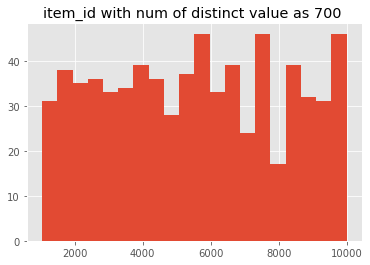

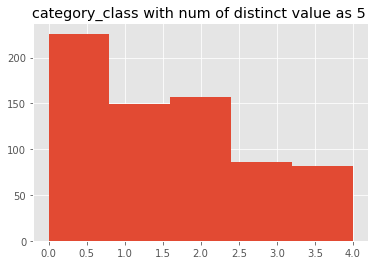

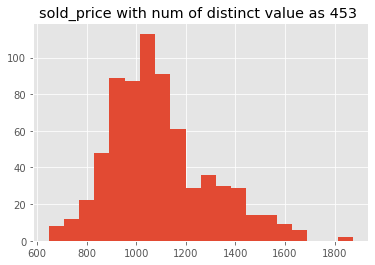

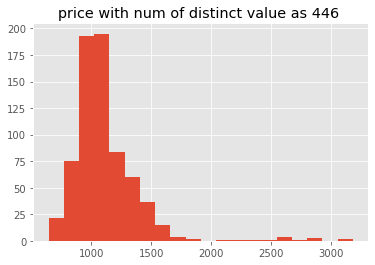

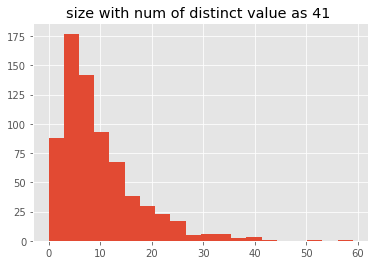

In [67]:
for i in train_df.describe().columns:
    ax = train_df[i].hist(bins=min(train_df[i].nunique(), 20))
    ax.set_title('{0} with num of distinct value as {1} '.format(i, train_df[i].nunique()))
    plt.show()

### Dependence of class on numerical columns 

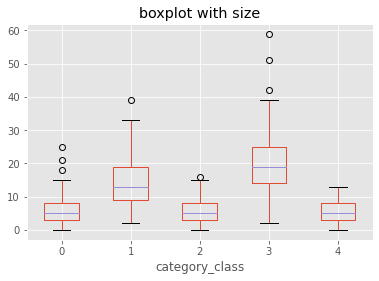

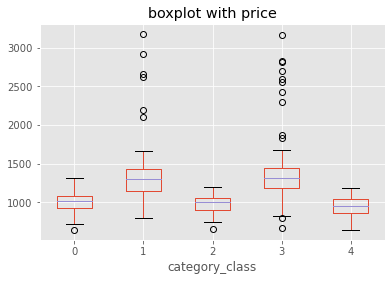

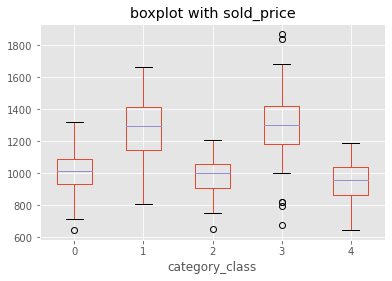

In [68]:
for i in ['size', 'price', 'sold_price']:
    ax = train_df.boxplot(by='category_class', column=[i])
    ax.set_title('boxplot with ' + i )
    plt.suptitle('')

Text(0.5, 1.0, 'box plot with price_ratio')

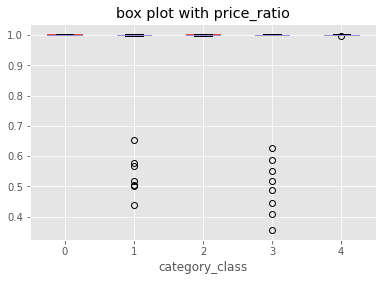

In [69]:
ax = train_df.assign(price_ratio= lambda df: df.sold_price/df.price).boxplot(by='category_class', column='price_ratio')
plt.suptitle('')
ax.set_title('box plot with price_ratio')

#### Remarks

* Box plot shows
    * price, sold_price, size typically higher for class 1 & 3
    * size even higher for class 3
    * price, sold_price lowest for for class 4
    * price_ratio is varied in class 1 or 3, we can try adding price_ratio
* TODO: Coorelation measure using two way anova test

### Dependence of class on listed_time

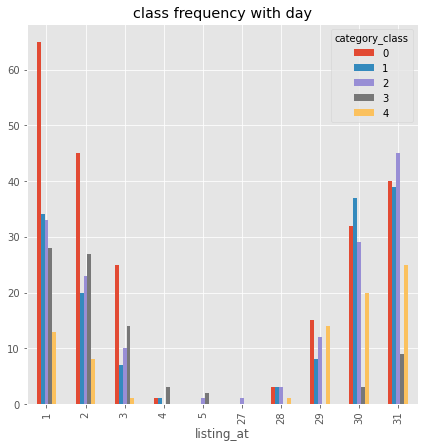

In [70]:
tmp_day_cross  = pd.crosstab(train_df['listing_at'].apply(lambda x: x.day), [train_df['category_class']])
(tmp_day_cross).plot(figsize=(7, 7), title='class frequency with day', kind='bar')
plt.show()

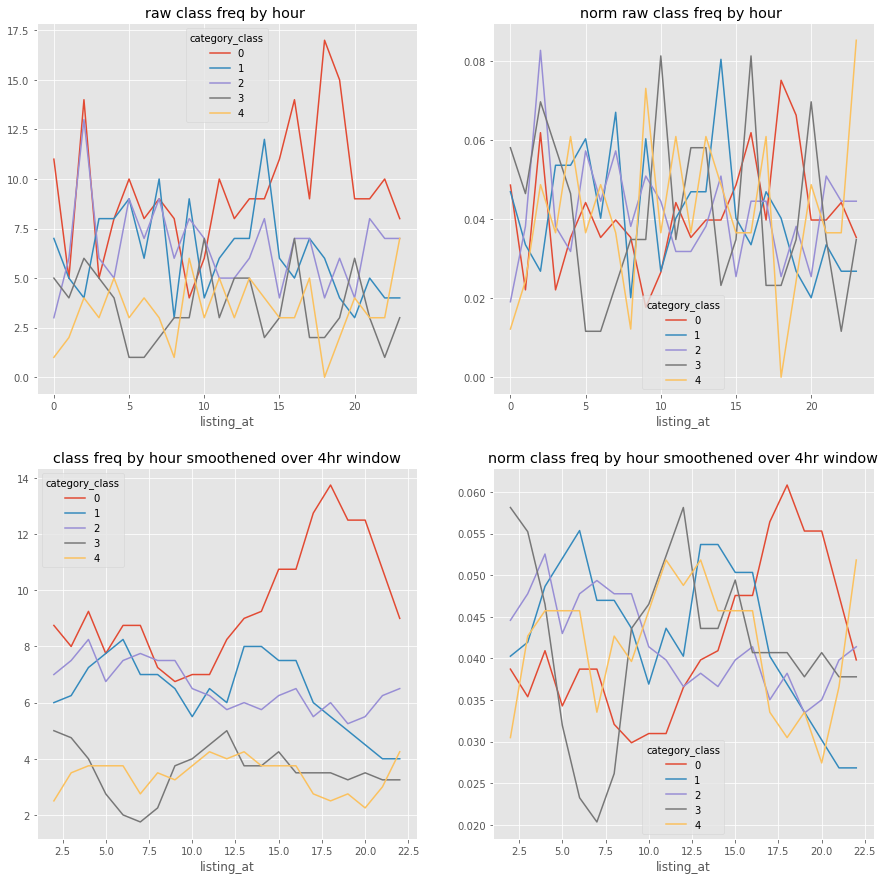

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=2)
tmp_hour_cross  = pd.crosstab(train_df['listing_at'].apply(lambda x: x.hour), [train_df['category_class']])

tmp_hour_cross.plot(figsize=(4, 4), title='raw class freq by hour ', ax=axes[0,0])
(tmp_hour_cross/tmp_hour_cross.sum(axis=0)).plot(figsize=(4, 4), title='norm raw class freq by hour ', ax=axes[0,1])
tmp_hour_cross  = pd.crosstab(train_df['listing_at'].apply(lambda x: x.hour), [train_df['category_class']])
tmp_hour_cross.rolling(4, center=True).mean().plot(figsize=(8, 8),
                                      title='class freq by hour smoothened over 4hr window',
                                       ax=axes[1,0])
(tmp_hour_cross/tmp_hour_cross.sum(axis=0)).rolling(4, center=True).mean().plot(figsize=(8, 8),
                                                                   title='norm class freq by hour smoothened over 4hr window',
                                                                   ax=axes[1,1])

fig.set_size_inches((15, 15))

#### Remarks

* categories depends on time
    * category 0 is listed more in night
    * cateogry 1 is listed more in afternoon and morning- can be statistically insignificant though

### Dependence of class on listed area

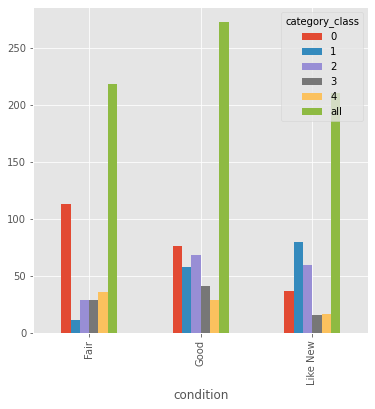

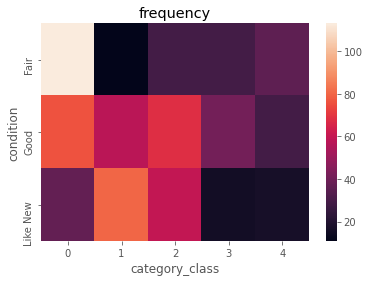

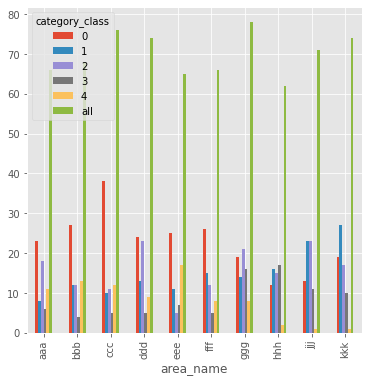

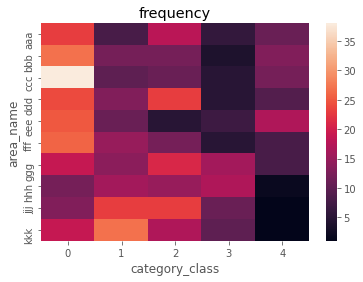

In [72]:
for i in ['condition', 'area_name']:
    tmp_cross = pd.crosstab(train_df[i], [train_df.category_class])
    tmp_cross['all'] = tmp_cross.sum(axis=1)
#     display(tmp_cross.head(5))
    ax = tmp_cross.plot(kind='bar', figsize=(6, 6))
    plt.show()
    ax = sns.heatmap(tmp_cross[[0, 1, 2, 3, 4]])
    ax.set_title('frequency')

### Inferences

* condition affects the class
    * 'fair' items more likely to class 0 while 
    * 'like new' more likely to be class 1 or 2
    
* area_name also affects the class
    * 'kkk', 'jjjj' more likely to be class 1,2 
    
* TODO: for quantitative analysis, chi square test to measure correlation between class

## Preprocessing and Feature engineering

* Give numbers to catogorical but numerical like variables
* Hot encoding for area_name 
* Throw away hash
* convert time to days and hours
* scaling before training


In [73]:
def preprocess_pd(df):
    # non-parametric preprocessing is done
    cleanup_nums = {"condition": {"Fair": -1, "Good": 0, "Like New": 1}}
    df = df.replace(cleanup_nums)
    df['listing_at_time'] = df['listing_at'].apply(lambda x: x.hour + x.minute/60.0) 
    df['listing_at_day'] = df['listing_at'].apply(lambda x: x.day)
    df = pd.get_dummies(df, columns=["area_name"])
    df = df.drop(['listing_at', 'item_tag_hash', 'item_id'], axis=1)
    return df

In [74]:
def feature_eng(train_df):
    return add_price_ratio(train_df)
def add_price_ratio(train_df):
    return train_df.assign(price_ratio=1.0*train_df['sold_price']/train_df['price'])

In [75]:
trainp_df = preprocess_pd(train_df)
# trainp_df = feature_eng(trainp_df)
testp_df = preprocess_pd(test_df)

# Experiments on Model Training 

* Baseline
* Trying simple classifiers
* Hyperparameter search on models

#### Baseline

In [76]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

In [78]:
X = trainp_df.drop(['category_class'], axis=1)
y = trainp_df['category_class']

#### Try simple classifiers

In [79]:
simple_classifiers = [
    DummyClassifier(),
    GaussianNB(),
    LogisticRegression(class_weight='balanced'),
    ]

#### Remarks

* class_weight was set to be balanced after looking at confusion matrix without balanced
* Refer to confusion matrix section for the relevant argument

In [80]:
for cl in simple_classifiers:
    clf = make_pipeline(preprocessing.StandardScaler(), cl)
    perf = cross_validate(clf, X, y, cv=5, return_train_score=True, scoring='f1_macro')
    print(cl, '{0} +- {1}'.format(round(perf['test_score'].mean(), 4), round(perf['test_score'].std(), 3)))

/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy wil

DummyClassifier() 0.2196 +- 0.021
GaussianNB() 0.4101 +- 0.075
LogisticRegression(class_weight='balanced') 0.5655 +- 0.031


#### Remarks

* dummy gives atleast 0.20
* naive bayes 0.40
* logistic regression 0.56

### Try more complex models with hyperparameter search

In [81]:
def print_result_gridsearch(clf):
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    display(pd.DataFrame(clf.__dict__['cv_results_'])[['mean_test_score',
                                           'std_test_score',
                                           'mean_train_score',
                                           'std_train_score',
                                           'params',
                                           'rank_test_score']].sort_values(by='rank_test_score').head(5))
    print()

#### SVM grid search

In [82]:
# class weight none
tuned_parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-3, 5e-4, 1e-4],
                     'svc__C': [1, 10, 100, 1000]},
                    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100, 1000]}]
tmp_clf = make_pipeline(preprocessing.StandardScaler(), SVC())
svm_clf = GridSearchCV(tmp_clf, tuned_parameters, cv=5,
                       scoring='f1_macro', return_train_score=True)
svm_clf.fit(X, y)
print_result_gridsearch(svm_clf)

Best parameters set found on development set:

{'svc__C': 1, 'svc__kernel': 'linear'}



,mean_test_score,std_test_score,mean_train_score,std_train_score,params,rank_test_score
12,0.583107,0.030033,0.639169,0.013076,"{'svc__C': 1, 'svc__kernel': 'linear'}",1
11,0.579101,0.018979,0.635534,0.014311,"{'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}",2
6,0.576358,0.017245,0.638573,0.011031,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}",3
10,0.574344,0.030316,0.654953,0.009409,"{'svc__C': 1000, 'svc__gamma': 0.0005, 'svc__kernel': 'rbf'}",4
13,0.574010,0.026481,0.646889,0.015508,"{'svc__C': 10, 'svc__kernel': 'linear'}",5


In [83]:
# class weight equal to inverse of class frequency
tuned_parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-3, 5e-4, 1e-4],
                     'svc__C': [1, 10, 100, 1000]},
                    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100, 1000]}]
tmp_clf = make_pipeline(preprocessing.StandardScaler(), SVC(class_weight='balanced'))
bal_svm_clf = GridSearchCV(tmp_clf, tuned_parameters, cv=5,
                       scoring='f1_macro', return_train_score=True)
bal_svm_clf.fit(X, y)
print_result_gridsearch(bal_svm_clf)

Best parameters set found on development set:

{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}



,mean_test_score,std_test_score,mean_train_score,std_train_score,params,rank_test_score
6,0.583657,0.026298,0.650465,0.010112,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}",1
10,0.581989,0.023870,0.662012,0.009149,"{'svc__C': 1000, 'svc__gamma': 0.0005, 'svc__kernel': 'rbf'}",2
11,0.581557,0.025657,0.647848,0.008950,"{'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}",3
7,0.580139,0.027287,0.637090,0.010258,"{'svc__C': 100, 'svc__gamma': 0.0005, 'svc__kernel': 'rbf'}",4
13,0.579754,0.019123,0.656644,0.013239,"{'svc__C': 10, 'svc__kernel': 'linear'}",5


#### Neural network grid search

In [84]:
tuned_parameters = [{'mlpclassifier__hidden_layer_sizes': [(100,), (200,), (50, ), (25, ), (15, )],
                     'mlpclassifier__activation': [ 'tanh', 'relu']
                    }]
tmp_clf = make_pipeline(preprocessing.StandardScaler(), MLPClassifier(alpha=1))
mlp_clf = GridSearchCV(tmp_clf, tuned_parameters, cv=5,
                       scoring='f1_macro',
                       return_train_score=True)
mlp_clf.fit(X, y)
print_result_gridsearch(mlp_clf)

/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

Best parameters set found on development set:

{'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': (50,)}



/Users/mohit/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,mean_test_score,std_test_score,mean_train_score,std_train_score,params,rank_test_score
2,0.579153,0.025297,0.651143,0.012479,"{'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': (50,)}",1
8,0.576991,0.034408,0.649488,0.014084,"{'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (25,)}",2
5,0.573929,0.026204,0.711159,0.006135,"{'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (100,)}",3
0,0.570771,0.034655,0.647888,0.013353,"{'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': (100,)}",4
6,0.565985,0.019440,0.733982,0.003915,"{'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (200,)}",5


#### Random Forest

In [85]:
tuned_parameters = [{'randomforestclassifier__min_samples_leaf': [1, 2, 4, 6, 10],
                     'randomforestclassifier__n_estimators': [5, 10, 15],
                     'randomforestclassifier__max_depth': [5, 10, 15]
                    }]
tmp_clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(class_weight='balanced'))
rf_clf = GridSearchCV(tmp_clf, tuned_parameters, cv=5,
                       scoring='f1_macro',
                       return_train_score=True)
rf_clf.fit(X, y)
print_result_gridsearch(rf_clf)

Best parameters set found on development set:

{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 15}



,mean_test_score,std_test_score,mean_train_score,std_train_score,params,rank_test_score
20,0.588123,0.015348,0.873880,0.013679,"{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 15}",1
38,0.565495,0.018915,0.802141,0.005644,"{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 15}",2
25,0.563165,0.033811,0.716777,0.013859,"{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__n_estimators': 10}",3
35,0.562701,0.004851,0.924112,0.005813,"{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 15}",4
40,0.555187,0.028216,0.735101,0.007351,"{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__n_estimators': 10}",5


#### Model selection

* SVM linear and with gaussian kernel performs the best
    * both are nearly similar
    * taking simpler model as they both are similar- linear

# Model Evaluation

#### Confusion matrix

In [86]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
def confusion_matrix_train_test(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    clf.fit(X_train, y_train)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    confusion_matrix(clf.predict(X_train), y_train)
    ax1 = sns.heatmap(confusion_matrix(y_train, clf.predict(X_train)), ax=axes[0], cmap="YlGnBu", annot=True)
    ax1.set_xlabel('predicted')
    ax1.set_ylabel('ideal')
    print('train_f1_score', f1_score(y_train, clf.predict(X_train), average='macro'))
    ax2 = sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), ax=axes[1], cmap="YlGnBu", annot=True)
    ax2.set_xlabel('predicted')
    ax2.set_ylabel('ideal')
    print('test_f1_score', f1_score(y_test, clf.predict(X_test), average='macro'))
    fig.set_size_inches((12, 5))
    fig.suptitle('train' + ' '*70 + 'test', fontsize=14, fontweight='bold')

####  Without using balanced class weighting 

train_f1_score 0.6597928815161825
test_f1_score 0.5121711913670366


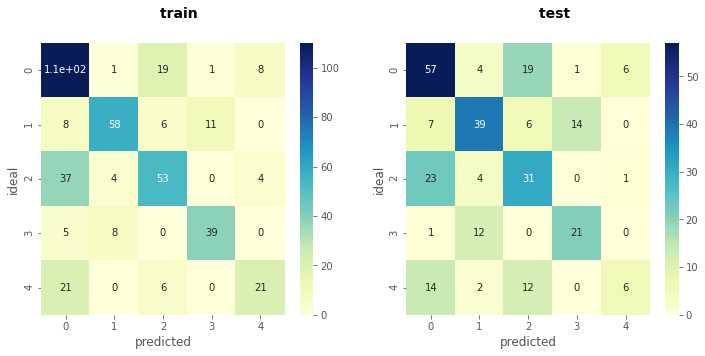

In [87]:
best_clf = svm_clf.best_estimator_
confusion_matrix_train_test(best_clf, X, y)

#### Remarks

* Class 0 is almost predicted right. There are lots of error from class 2 to class 0 and class 4 to class 1
    * This is due to optimisation for accuracy as class 0 has a lot of elements
    * Our optimisation for f1 score is sub-optimal
    * One possible way could be to put class weight as inverse of number of samples for each class

####  With using balanced class weighting 

train_f1_score 0.6752613222694276
test_f1_score 0.511298639062267


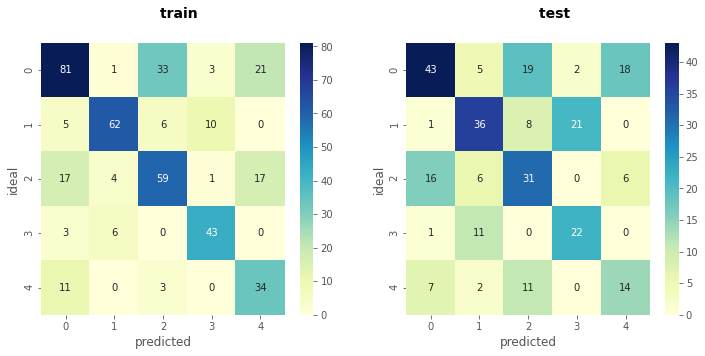

In [88]:
best_clf = bal_svm_clf.best_estimator_
confusion_matrix_train_test(best_clf, X, y)

# Prediction

In [89]:
best_clf = bal_svm_clf.best_estimator_

In [90]:
trainp_df = preprocess_pd(train_df)
X = trainp_df.drop(['category_class'], axis=1)
y = trainp_df['category_class']
testp_df = preprocess_pd(test_df)
test_X = testp_df.drop(['category_class'], axis=1)

In [91]:
best_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, class_weight='balanced', gamma=0.001))])

#### Sanity check on training data

In [92]:
print(confusion_matrix(best_clf.predict(X), y))
print(f1_score(y, best_clf.predict(X), average='macro'))
print(accuracy_score(y, best_clf.predict(X)))

[[127   5  26   3  16]
 [  6 109   8  19   0]
 [ 46  10  94   0   8]
 [  6  22   1  64   0]
 [ 41   3  28   0  58]]
0.6476985706706444
0.6457142857142857


In [93]:
test_predicted_y = best_clf.predict(test_X)

In [94]:
test_df['category_class'] = test_predicted_y

In [95]:
test_df[['item_id', 'category_class']].to_csv('prediction.csv',index=False)

In [97]:
print(test_df[['item_id', 'category_class']].to_csv(index=False))

item_id,category_class
6000,2
5532,0
6797,1
3325,3
5447,2
7191,0
9326,4
7136,0
7391,0
8131,3
2519,4
6530,0
4216,2
5210,3
1945,0
4215,2
6588,3
2162,1
8626,0
5131,4
4587,2
6557,2
2057,2
4741,3
6042,2
7805,0
3771,2
7307,4
2062,2
4979,4
2293,0
8063,1
6098,2
8215,0
1234,1
5316,4
1488,2
5744,1
2659,2
4694,2
5108,4
5319,4
8024,3
9746,2
4268,1
5474,1
7785,3
1311,2
4161,1
9764,0
6060,2
4503,4
1124,1
2156,3
4442,2
8839,2
3224,2
6085,1
7373,0
6349,0
3196,2
3012,2
1824,0
4092,1
1545,1
3360,0
3018,2
9263,0
7755,4
7660,4
9818,4
2052,4
2960,3
9212,3
5646,0
3975,4
9511,3
5408,4
1685,2
3130,0
8437,0
8896,4
8231,1
9032,4
1006,0
3218,2
2826,2
8999,1
2523,1
7835,1
8451,3
3495,4
9239,1
7576,4
1752,3
7024,2
4805,0
9218,2
3090,0
7565,0
8397,3
5726,4
1412,3
2594,3
4252,0
8096,2
7002,2
2592,1
4993,3
3877,1
6894,2
7772,2
2454,1
7101,4
7792,2
7492,0
6996,3
2082,0
2928,4
8598,4
1712,0
3604,1
3266,4
7358,0
2256,4
3100,4
1611,0
8159,2
2704,0
6684,0
4733,0
9712,4
6304,1
4655,3
1386,4
2241,2
2448,0
2832,3
8188,2
2118